## Predict TOO with multiple models

In [ ]:
## two step multinomial model
# for each cancer type (fit):
    # choose regions trained on tissue
    # save region set and thresholds
    # train logistic regression
# for each test sample(transform):
    # output prob of each cancer type
    # threshold to 90 pct spec using max prob for all samples, output 0/1s
    # if 0, output 0, if 1, output class label --> 
    # create new multiclass passthrough model that generates ModelResult(predictions(0,1,2...N), scores(max probs))
# run model result through multiclass metric computer

In [25]:
a = np.array([1,2,3])
1-a

array([ 0, -1, -2])

In [4]:
import numpy as np
import pandas as pd
from typing import List
import seaborn as sns
from matplotlib import pyplot as plt
import os

from featureio import FeatureIO 
from calzone import Calzone

from pineapple.contrib.components.data_factories.matrix_factory import MatrixFactory as mf
from pineapple.contrib.components.transformers.methyl.poisson_outlier import ChooseSettingsAndRegionsForPoissonV2
from pineapple.contrib.specs.transformer_specs import ChooseSettingsAndRegionsForPoissonSpecV2

#from pineapple.contrib.results.results_loader import load_results
from pineappleflow.core.loaders.contrib.experiment_loader import ExperimentLoader
import pineappleflow.core.experiment_context as experiment_context
import datetime
experiment_context.reset_context(0, "x", "x", datetime.datetime(2021, 7, 19,0,0))

from collections import defaultdict, Counter
print("a")

a


In [205]:
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [257]:



cancer_type_to_train_sets = {"Lung_Cancer":["lung_cancer_methyl_DMR_tissue_ds_FF_merged"],
                             "Liver_Cancer":["liver_cancer_tissue_ds_FF_v1"],
                             "Prostate_Cancer":["prostate_cancer_tissue_ds_FF_v1"],
                             "Ovarian_Cancer":["ovarian_cancer_tissue_ds_FF_v1"],
                             "Uterine_Cancer":["uterine_cancer_tissue_ds_FF_v1"],
                             "Pancreatic_Cancer":["pancreatic_cancer_tissue_ds_FF_v1"],
                             "Breast_Cancer":["breast_cancer_tissue_ds_FF_v1"],
                             "Stomach_Cancer":["stomach_cancer_tissue_ds_FF_v1"],
                             "Kidney_Cancer":["kidney_cancer_tissue_ds_FF_v1"],
                             "Lymphoma":["nonhodgkinslymphoma_cancer_tissue_ds_FF_v1"],
                             "CRC":["colorectal_tissue_cancer_stage_IV_chemo_n",
                                            "colorectal_tissue_cancer_stage_IV_chemo_y",
                                            "colorectal_tissue_cancer_stage_III_chemo_n",
                                            "colorectal_tissue_cancer_stage_III_chemo_y",
                                            "colorectal_tissue_cancer_stage_II_chemo_n",
                                            "colorectal_tissue_cancer_stage_II_chemo_y",
                                            "colorectal_tissue_cancer_stage_I_chemo_n",
                                            "colorectal_tissue_cancer_stage_I_chemo_y"]
                            }

healthy_plasma = ["colorectal_plasma_healthy_polyp_n","colorectal_plasma_healthy_polyp_y"]

cancer_type_to_plasma_tclasses = {"Lung_Cancer":["lung_cancer_centipedeC_cpg_dense_v2"],
                             "Liver_Cancer":["liver_cancer_centipedeC_cpg_dense_v2"],
                             "Prostate_Cancer":["prostate_cancer_centipedeC_cpg_dense_v2"],
                             "Ovarian_Cancer":["ovarian_cancer_centipedeC_cpg_dense_v2"],
                             "Uterine_Cancer":["uterine_cancer_centipedeC_cpg_dense_v2"],
                             "Pancreatic_Cancer":["pancreatic_cancer_centipedeC_cpg_dense_v2"],
                             "Breast_Cancer":["breast_cancer_centipedeC_cpg_dense_v3"],
                             #"Esophageal_Cancer":["esophageal_cancer_centipedeC_cpg_dense_v1"],
                             "CRC":["colorectal_plasma_cancer_stage_IV_chemo_n",
                                    "colorectal_plasma_cancer_stage_IV_chemo_y"]
                            }  

In [262]:
mat = mf.create_from_training_classes(cancer_type_to_plasma_tclasses["CRC"], "mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1", [0,0] )
mat.sample_metadata[0].cancer_type

Missed Redis cache for 24 datasets with timestamp 2021-07-18 00:00:00, reading from BigQuery instead


'Colorectal Cancer'

In [265]:
a = np.array([True,True]) | np.array([False,True])
a

array([ True,  True])

In [15]:
def fit_data(mat):
    region_spec = ChooseSettingsAndRegionsForPoissonSpecV2.voluptuous_validator(ChooseSettingsAndRegionsForPoissonSpecV2)\
                ({'name': 'choose_settings_and_regions_for_poisson_v2', 
                  'kwargs': {'desired_noise_floor': 1e-5, 'min_prob_clean': .95, 
                             'max_sigma_for_healthy_samples': 3.3, 'min_effect_size': 100.0, 'min_features' : 1, 'pessimistic_effect_size_ci': .95}})
    choose_regions = ChooseSettingsAndRegionsForPoissonV2.from_spec(region_spec)
    choose_regions.fit(mat)
    fitted_mat = choose_regions.select_best_features_per_region(x=mat.x, included_sample_dim=True)
    hmf_rates = fitted_mat[...,0]/(fitted_mat[...,1] + 1) # do we want to use rates or counts here??????
    #print(mat.column_metadata[0])
    #regions = [f'{reg["chrm"]}:{reg["start"]}-{reg["stop"]}' for reg in mat.column_metadata]
    regions = range(0,len(mat.column_metadata))
    df_fitted_mat_cancer = pd.DataFrame(hmf_rates[mat.y==1], columns=regions)
    df_fitted_mat_healthy = pd.DataFrame(hmf_rates[mat.y==0], columns=regions)
    
    return df_fitted_mat_cancer, df_fitted_mat_healthy, choose_regions.best_feature_per_region

In [238]:
def confusion_matrix(y, y_pred, title='multicancer', plot=True):
    combos = list(zip(y, y_pred))
    #print(y_pred)
    matches = []
    sens = []
    for i in np.unique(y):
        matrix_row = []
        for j in np.unique(y_pred):
            matrix_row.append(combos.count((i,j)))
            if i==j:
                sens.append(combos.count((i,j))/float(list(y).count(i)))
        matches.append(matrix_row)
    arr_matches = np.array(matches)
    percents = arr_matches / arr_matches.sum(axis=1, keepdims=True)
    df_matches = pd.DataFrame(arr_matches, columns=np.unique(y_pred),index=np.unique(y))
    df_percents = pd.DataFrame(percents, columns=np.unique(y_pred),index=np.unique(y))
    print(percents.shape)
    print(df_matches.shape)
    if plot is True:
        plt.figure()
        ax = sns.heatmap(df_percents, annot=df_matches, cmap="GnBu")
        plt.title(title, size=16)
        ax.set_xlabel("Predicted Label", size=14)
        ax.set_ylabel("True Label", size=14)
    
    return np.median(sens)


In [155]:
a = np.array([[1,2,3],[4,5,6]])
a / np.sum(a, axis=1, keepdims=True)

array([[0.16666667, 0.33333333, 0.5       ],
       [0.26666667, 0.33333333, 0.4       ]])

## generate plasma training classes for training by splitting existing plasma classes

In [2]:
stage_dict = {"I":"I","II":"II","III":"III","IV":"IV",
             "IA":"I","IB":"I","IC":"I",
             "IIA":"II","IIB":"II","IIC":"II",
             "IIIA":"III","IIIB":"III","IIIC":"III",
             "IV":"IV","IVA":"IV","IVB":"IV","IVC":"IV",
             None:"Unknown", "Unavailable":"Unknown"}

def split_training_class_stratified(training_classes):
    dsids = []
    for tc in training_classes:
        dsids.extend(FeatureIO().get_datasets_for_training_class(tc))
    
    metas = Calzone.get_dataset_metadata_with_ids(dsids)
    labels = [m.raw_sample_metadata['lims_top_diagnosis']['stage'] for m in metas]
    labels = [stage_dict[l] for l in labels]
    
    # remove unknown stage samples
    unk_index = labels.index("Unknown")
    labels.pop(unk_index)
    dsids.pop(unk_index)
    print(f"{training_classes}: Stages: {Counter(labels)}")
    
    # if only one sample per stage, 
    for stage in ["I","II","III","IV"]:
        if labels.count(stage) == 1:
            labels = [labels[0] if l==stage else l for l in labels]
          
    X_train, X_test, y_train, y_test = train_test_split(dsids, labels, test_size=0.5, 
                                                        stratify=labels, random_state=42)
    #return X_train, X_test, y_train, y_test
    FeatureIO().create_training_class(training_class_name=f'{training_classes[0]}_train', 
                                      desc='stage stratified 50% split of centipede C plasmas',
                                      datasets=X_train)
    print(len(FeatureIO().get_datasets_for_training_class(f"{training_classes[0]}_train")))
                     
    FeatureIO().create_training_class(training_class_name=f'{training_classes[0]}_test', 
                                      desc='stage stratified 50% split of centipede C plasmas',
                                      datasets=X_test)
    print(len(FeatureIO().get_datasets_for_training_class(f"{training_classes[0]}_test")))
    
    
    

In [65]:
split_training_class_stratified(["lung_cancer_centipedeC_cpg_dense_v2"]) # _train_v2, _test_v2

['lung_cancer_centipedeC_cpg_dense_v2']: Stages: Counter({'III': 22, 'IV': 20, 'II': 12, 'I': 10})


In [ ]:
split_training_class_stratified(["liver_cancer_centipedeC_cpg_dense_v2"])

In [77]:
split_training_class_stratified(["prostate_cancer_centipedeC_cpg_dense_v2"])

['prostate_cancer_centipedeC_cpg_dense_v2']: Stages: Counter({'III': 31, 'II': 22, 'IV': 4, 'I': 2})
29
30


In [78]:
split_training_class_stratified(["ovarian_cancer_centipedeC_cpg_dense_v2"])

['ovarian_cancer_centipedeC_cpg_dense_v2']: Stages: Counter({'III': 46, 'I': 2, 'IV': 2})
25
25


In [87]:
split_training_class_stratified(["uterine_cancer_centipedeC_cpg_dense_v2"])

Missed Redis cache for ttl_key TS-212547669, reading from BigQuery instead


['uterine_cancer_centipedeC_cpg_dense_v2']: Stages: Counter({'I': 35, 'III': 8, 'II': 7})
25
25


In [88]:
split_training_class_stratified(["pancreatic_cancer_centipedeC_cpg_dense_v2"])

['pancreatic_cancer_centipedeC_cpg_dense_v2']: Stages: Counter({'II': 27, 'III': 23, 'IV': 21, 'I': 9, 'Unknown': 2})
41
41


In [100]:
split_training_class_stratified(["breast_cancer_centipedeC_cpg_dense_v3"])

['breast_cancer_centipedeC_cpg_dense_v3']: Stages: Counter({'II': 22, 'I': 15, 'III': 4, 'Unknown': 3, 'IV': 1})
22
23


In [ ]:
split_training_class_stratified(["breast_cancer_centipedeC_cpg_dense_v3"])

In [9]:
training_classes = ["colorectal_plasma_cancer_stage_IV_chemo_n","colorectal_plasma_cancer_stage_IV_chemo_y"]
dsids = []
for tc in training_classes:
    dsids.append(FeatureIO().get_datasets_for_training_class(tc))
    
labels = ["chemo_y"]*len(dsids[0]) + ["chemo_n"]*len(dsids[1])
dsids = [dsid for sublist in dsids for dsid in sublist] #flatten

X_train, X_test, y_train, y_test = train_test_split(dsids, labels, test_size=0.5, 
                                                        stratify=labels, random_state=42)
    
FeatureIO().create_training_class(training_class_name="colorectal_plasma_cancer_stage_IV_chemo_yn_train", 
                                      desc='stage stratified 50% split of centipede C plasmas',
                                      datasets=X_train)
print(len(FeatureIO().get_datasets_for_training_class("colorectal_plasma_cancer_stage_IV_chemo_yn_train")))
                     
FeatureIO().create_training_class(training_class_name='colorectal_plasma_cancer_stage_IV_chemo_yn_test', 
                                      desc='stage stratified 50% split of centipede C plasmas',
                                      datasets=X_test)
print(len(FeatureIO().get_datasets_for_training_class('colorectal_plasma_cancer_stage_IV_chemo_yn_test')))

12
12


In [259]:
# update training class lists with plasma in training
cancer_type_to_train_sets = {"Lung_Cancer":["lung_cancer_methyl_DMR_tissue_ds_FF_merged","lung_cancer_centipedeC_cpg_dense_v2_train_v2"],
                             "Liver_Cancer":["liver_cancer_tissue_ds_FF_v1","liver_cancer_centipedeC_cpg_dense_v2_train"],
                             "Prostate_Cancer":["prostate_cancer_tissue_ds_FF_v1","prostate_cancer_centipedeC_cpg_dense_v2_train"],
                             "Ovarian_Cancer":["ovarian_cancer_tissue_ds_FF_v1","ovarian_cancer_centipedeC_cpg_dense_v2_train"],
                             "Uterine_Cancer":["uterine_cancer_tissue_ds_FF_v1","uterine_cancer_centipedeC_cpg_dense_v2_train"],
                             "Pancreatic_Cancer":["pancreatic_cancer_tissue_ds_FF_v1","pancreatic_cancer_centipedeC_cpg_dense_v2_train"],
                             "Breast_Cancer":["breast_cancer_tissue_ds_FF_v1","breast_cancer_centipedeC_cpg_dense_v3_train"],
                             "Stomach_Cancer":["stomach_cancer_tissue_ds_FF_v1"],
                             "Kidney_Cancer":["kidney_cancer_tissue_ds_FF_v1"],
                             "Lymphoma":["nonhodgkinslymphoma_cancer_tissue_ds_FF_v1"],
                             "CRC":["colorectal_tissue_cancer_stage_IV_chemo_n",
                                            "colorectal_tissue_cancer_stage_IV_chemo_y",
                                            "colorectal_tissue_cancer_stage_III_chemo_n",
                                            "colorectal_tissue_cancer_stage_III_chemo_y",
                                            "colorectal_tissue_cancer_stage_II_chemo_n",
                                            "colorectal_tissue_cancer_stage_II_chemo_y",
                                            "colorectal_tissue_cancer_stage_I_chemo_n",
                                            "colorectal_tissue_cancer_stage_I_chemo_y",
                                            "colorectal_plasma_cancer_stage_IV_chemo_n",
                                            "colorectal_plasma_cancer_stage_IV_chemo_y"]
                            }

healthy_plasma_train = ["colorectal_plasma_healthy_polyp_n","colorectal_plasma_healthy_polyp_y"]

healthy_plasma_test = ['Neg_noM4_centipedeC_cpg_dense_v3',
                  'M4_negs_cpg_dense_no96plasmas_v1']

cancer_type_to_plasma_test_sets = {"Lung_Cancer":["lung_cancer_centipedeC_cpg_dense_v2_test_v2"],
                             "Liver_Cancer":["liver_cancer_centipedeC_cpg_dense_v2_test"],
                             "Prostate_Cancer":["prostate_cancer_centipedeC_cpg_dense_v2_test"],
                             "Ovarian_Cancer":["ovarian_cancer_centipedeC_cpg_dense_v2_test"],
                             "Uterine_Cancer":["uterine_cancer_centipedeC_cpg_dense_v2_test"],
                             "Pancreatic_Cancer":["pancreatic_cancer_centipedeC_cpg_dense_v2_test"],
                             "Breast_Cancer":["breast_cancer_centipedeC_cpg_dense_v3_test"],
                             #"Esophageal_Cancer":["esophageal_cancer_centipedeC_cpg_dense_v1"],
                             "CRC":["colorectal_plasma_cancer_stage_IV_chemo_n",
                                    "colorectal_plasma_cancer_stage_IV_chemo_y"]
                            }  

CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 41 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


Lung_Cancer
2
Liver_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 31 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Prostate_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 27 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Ovarian_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 23 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Uterine_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 39 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Pancreatic_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 42 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Breast_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 13 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Stomach_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 14 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Kidney_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 19 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Lymphoma


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 8 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
CRC


MATRIX: 24 duplicate sample ids found!
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 88 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2


AttributeError: 'DataFrame' object has no attribute 'set_indes'

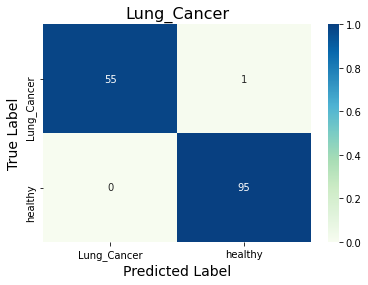

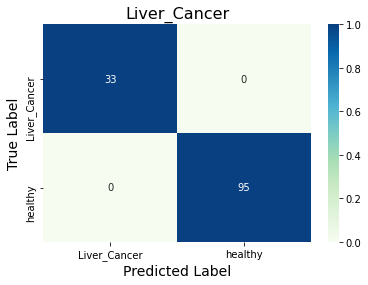

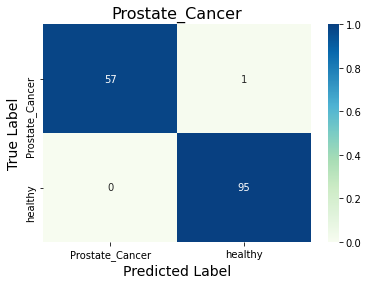

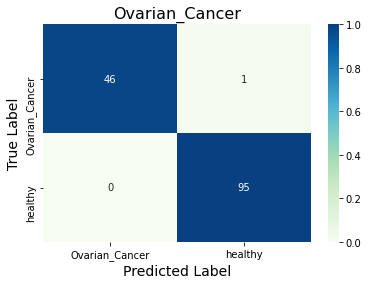

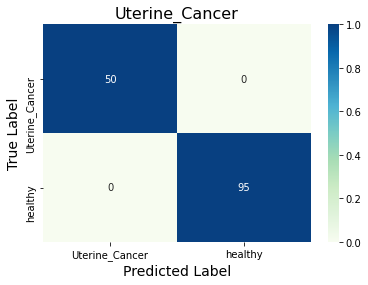

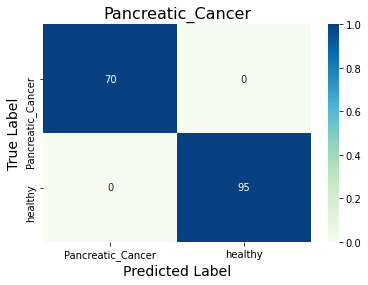

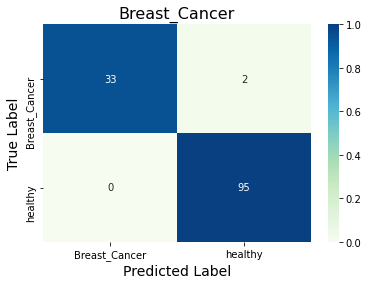

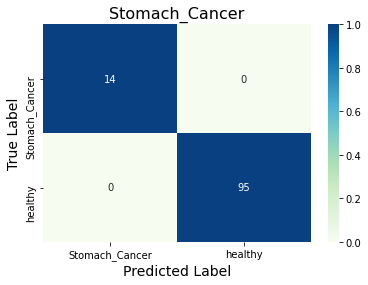

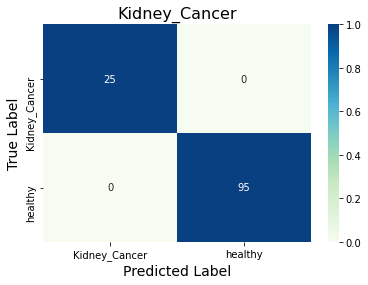

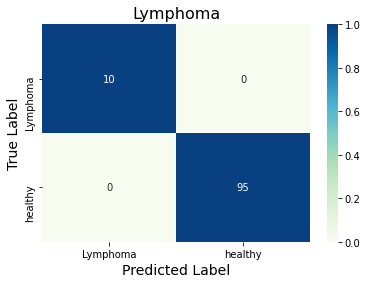

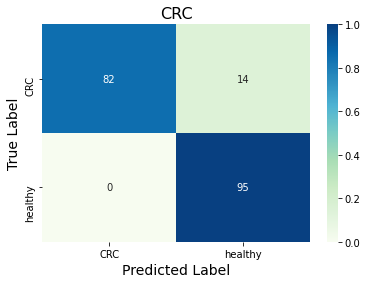

In [18]:
# get thresholds and train log reg models on tissue/plasma for each cancer type
models = {}
#dfs_tissue = []
threshold_dict = {}
dfs_train = []
for cancer_type, tclasses in cancer_type_to_train_sets.items():
    print(cancer_type)
    mat_tissue = mf.create_from_training_classes(training_classes=tclasses + healthy_plasma_train,
                                          feature_str="mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1",
                                          class_labels=[1]*len(tclasses) + [0,0]
                                         )    
    df_cancer, df_healthy, cpg_thresholds = fit_data(mat_tissue)
    #dfs_tissue.append(df_cancer)
    threshold_dict[cancer_type] = cpg_thresholds
    
    df_cancer_healthy = pd.concat([df_cancer, df_healthy], axis=0)
    df_cancer_healthy_log = df_cancer_healthy.apply(lambda x: np.log(x+1))
    
    labels = [cancer_type]*len(df_cancer) + ["healthy"]*len(df_healthy)
    cv = StratifiedKFold(n_splits=3)
    model = LogisticRegression(multi_class='multinomial', solver='saga', 
                             penalty='l1', C=10)
    model.fit(X=df_cancer_healthy_log, y=labels)
    models[cancer_type] = model
    y_pred = cross_val_predict(model, df_cancer_healthy_log, labels)
    confusion_matrix(labels, y_pred, cancer_type)
    
    df_cancer_log = df_cancer.apply(lambda x: np.log(x+1))
    df_cancer_log["cancer_type"] = cancer_type
    dfs_train.append(df_cancer_log)
    
df_healthy_log = df_healthy.apply(lambda x: np.log(x+1))
df_healthy_log["cancer_type"] = "healthy" 
df_train = pd.concat(dfs_train + [df_healthy_log], axis=0)
df_train = df_train.set_index("cancer_type")

In [19]:
## can't do this. threshold test data based on true TOO.

# import test plasma data set, predict with each model, output model scores
# df_train = df_train.set_index("cancer_type") #contains log hmf rates
# dfs_test = []
# for cancer_type, tclasses in cancer_type_to_plasma_test_sets.items():
#     mat_test = mf.create_from_training_classes(training_classes=tclasses,
#                                           feature_str="mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1",
#                                           class_labels=[1]*len(tclasses)
#                                          )    
#     data = []
#     cpg_cutoffs_i = threshold_dict[cancer_type]
#     hmf_rates = mat_test.x[...,0] / (mat_test.x[...,1] + 1)
#     assert not np.isnan(hmf_rates).any()
#     for i , cutoff in enumerate(cpg_cutoffs_i):
#         data.append(hmf_rates[:,i,int(cutoff)])
#     df_data = pd.DataFrame(data).T # samples x regions
#     df_data_log = df_data.apply(lambda x: np.log(x+1))
#     df_data_log["cancer_type"] = cancer_type
#     dfs_test.append(df_data_log)

# # add healthies
# mat_plasma_healthy = mf.create_from_training_classes(training_classes=healthy_plasma_test,
#                                           feature_str="mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1",
#                                           class_labels=[0]*len(tclasses)
#                                          )    
# data = []
# cpg_cutoffs_i = pd.DataFrame.from_dict(threshold_dict).mean(axis=1)
# hmf_rates = mat_plasma_healthy.x[...,0] / (mat_plasma_healthy.x[...,1] + 1)
# assert not np.isnan(hmf_rates).any()
# for i , cutoff in enumerate(cpg_cutoffs_i):
#     data.append(hmf_rates[:,i,int(np.round(cutoff,0))])
# df_data = pd.DataFrame(data).T # samples x regions
# df_data_log = df_data.apply(lambda x: np.log(x+1))
# df_data_log["cancer_type"] = "healthy"
# dfs_test.append(df_data_log)
    
# df_test = pd.concat(dfs_test, axis=0)
# df_test = df_test.set_index("cancer_type") # contains log hmf rates

9
0.4782608695652174


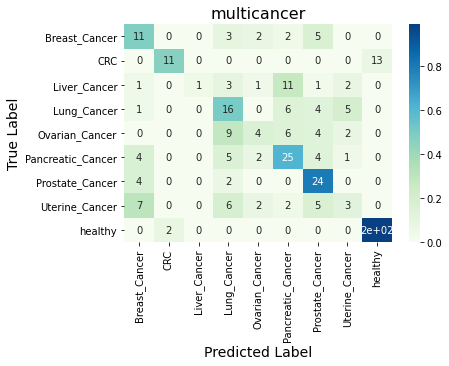

In [21]:
# can't do this. threshold test data on true TOO cpg cutoff

# train one multinomial model and predict on test set
# model = LogisticRegression(multi_class='multinomial', solver='saga', 
#                              penalty='l1', C=10)
# model.fit(df_train, df_train.index)
# y_pred = model.predict(df_test)
# acc = confusion_matrix(df_test.index, y_pred, "multicancer")
# print(acc)


In [23]:
# score test data on each model in the ensemble
cancer_types = list(np.unique(df_test.index))
scores = {}
for cancer_type in cancer_types:
    if cancer_type == "healthy":
        continue
    model_i = models[cancer_type]
    probs = model_i.predict_proba(df_test)
    scores[cancer_type] = list([x[1] for x in probs])


df_scores = pd.DataFrame.from_dict(scores)
df_scores = df_scores.set_index(df_test.index)
#print(df_scores.head())
df_scores_healthy = df_scores[df_scores.index=="healthy"]
#print(df_scores_healthy.shape)
healthy_means = df_scores_healthy.mean(axis=0)
#print(healthy_means)
healthy_sds = df_scores_healthy.std(axis=0)
#print(healthy_sds)
df_scores_z = (df_scores - healthy_means)/healthy_sds
#print(df_scores_z.shape)


9
0.0


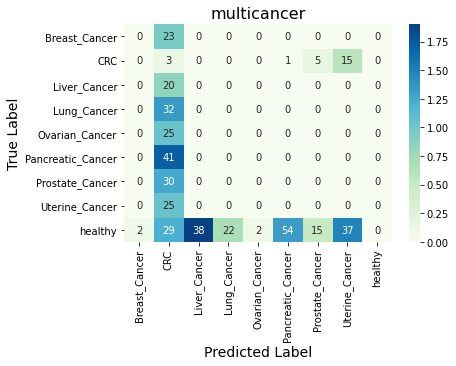

In [25]:
# make TOO calls via max score and construct confusion matrix
max_scores = df_scores_z.apply(max, axis=1)
y_pred = df_scores_z.apply(lambda row: list(df_scores_z.columns)[np.argmax(row)], axis=1)

color_dict = dict(zip(cancer_type_to_train_sets.keys(),
                      ["red","green","magenta","yellow","purple","black","brown","pink","lightblue","lightgreen","orange"]))
color_dict.update({"healthy":"blue"})
acc = confusion_matrix(df_scores_z.index, y_pred, "multicancer")
print(acc)
# plt.figure()
# plt.scatter(range(len(max_scores)),
#             sorted(max_scores),
#             color=[color_dict[ct] for ct in np.array(df_scores_z.index)[np.argsort(max_scores)]]
#            )

## Use tissue-specific region sets to train ensemble of logistic models

In [26]:
# note setting for min_features and min_effect_size here
def fit_and_transform_data(mat, min_features):
    region_spec = ChooseSettingsAndRegionsForPoissonSpecV2.voluptuous_validator(ChooseSettingsAndRegionsForPoissonSpecV2)\
                ({'name': 'choose_settings_and_regions_for_poisson_v2', 
                  'kwargs': {'desired_noise_floor': 1e-5, 'min_prob_clean': .95, 
                             'max_sigma_for_healthy_samples': 3.3, 'min_effect_size': 0.0, 'min_features' : min_features, #'pessimistic_effect_size_ci': .95
                            }})
    choose_regions = ChooseSettingsAndRegionsForPoissonV2.from_spec(region_spec)
    choose_regions.fit(mat)
    fitted_mat = choose_regions.transform(mat)
    #hmf_rates = fitted_mat[...,0]/(fitted_mat[...,1] + 1) # do we want to use rates or counts here??????
    
    
    return choose_regions, fitted_mat.x

In [172]:
# plot min features vs. average per tissue CV accuracy
per_minreg_mean_accuracies = []
per_minreg_std_errs = []
min_features_to_try = [2,10,100,300,500,515,535,551]
for MIN_FEATURES in min_features_to_try:
    accuracies = []
    for cancer_type, tclasses in cancer_type_to_train_sets.items():
        print(cancer_type)
        mat_tissue = mf.create_from_training_classes(training_classes=tclasses + healthy_plasma_train,
                                          feature_str="mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1",
                                          class_labels=[1]*len(tclasses) + [0,0]
                                         )    
        outlier_model, df_cancer_healthy = fit_and_transform_data(mat_tissue, MIN_FEATURES)
        labels = mat_tissue.y
        df_cancer_healthy = pd.DataFrame(df_cancer_healthy[:,:,0] / (df_cancer_healthy[:,:,1] + 1))
        df_cancer_healthy = df_cancer_healthy.apply(lambda x: np.log(x+1), axis=0)
    
        cv = StratifiedKFold(n_splits=3)
        logreg_model = LogisticRegression(multi_class='multinomial', solver='saga', 
                             penalty='l1', C=10)
        logreg_model.fit(X=df_cancer_healthy, y=labels)
        y_pred = cross_val_predict(logreg_model, df_cancer_healthy, labels)
        acc = confusion_matrix(labels, y_pred, cancer_type, plot=False)
        accuracies.append(acc)
    
    per_minreg_mean_accuracies.append(np.mean(accuracies))
    per_minreg_std_errs.append(np.std(accuracies)/np.sqrt(len(accuracies)))


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 41 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


Lung_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 31 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Liver_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 27 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Prostate_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 23 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Ovarian_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 39 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Uterine_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 42 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Pancreatic_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 13 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Breast_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 14 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Stomach_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 19 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Kidney_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 8 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Lymphoma


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 88 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
CRC


MATRIX: 24 duplicate sample ids found!
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 41 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Lung_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 31 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Liver_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 27 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Prostate_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 23 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Ovarian_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 39 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Uterine_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 42 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Pancreatic_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 13 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Breast_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 14 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Stomach_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 19 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Kidney_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 8 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Lymphoma


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 88 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
CRC


MATRIX: 24 duplicate sample ids found!
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 41 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Lung_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 31 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Liver_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 27 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Prostate_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 23 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Ovarian_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 39 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Uterine_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 42 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Pancreatic_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 13 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Breast_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 14 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Stomach_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 19 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Kidney_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 8 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Lymphoma


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 88 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
CRC


MATRIX: 24 duplicate sample ids found!
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 41 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Lung_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 31 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Liver_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 27 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Prostate_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 23 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Ovarian_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 39 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Uterine_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 42 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Pancreatic_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 13 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Breast_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 14 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Stomach_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 19 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Kidney_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 8 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Lymphoma


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 88 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
CRC


MATRIX: 24 duplicate sample ids found!
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 41 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Lung_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 31 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Liver_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 27 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Prostate_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 23 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Ovarian_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 39 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Uterine_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 42 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Pancreatic_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 13 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Breast_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 14 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Stomach_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 19 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Kidney_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 8 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Lymphoma


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 88 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
CRC


MATRIX: 24 duplicate sample ids found!
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 41 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Lung_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 31 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Liver_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 27 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Prostate_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 23 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Ovarian_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 39 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Uterine_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 42 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Pancreatic_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 13 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Breast_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 14 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Stomach_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 19 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Kidney_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 8 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Lymphoma


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 88 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
CRC


MATRIX: 24 duplicate sample ids found!
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 41 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Lung_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 31 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Liver_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 27 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Prostate_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 23 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Ovarian_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 39 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Uterine_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 42 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Pancreatic_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 13 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Breast_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 14 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Stomach_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 19 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Kidney_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 8 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Lymphoma


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 88 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
CRC


MATRIX: 24 duplicate sample ids found!
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 41 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Lung_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 31 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Liver_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 27 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Prostate_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 23 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Ovarian_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 39 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Uterine_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 42 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Pancreatic_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 13 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Breast_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 14 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Stomach_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 19 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Kidney_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 8 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
Lymphoma


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 88 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


2
CRC


MATRIX: 24 duplicate sample ids found!


2


NameError: name 'min_fetures_to_try' is not defined

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'mean per-tissue model accuracy')

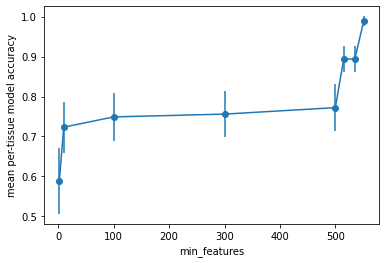

In [173]:
plt.figure()
plt.scatter(min_features_to_try, per_minreg_mean_accuracies)
plt.errorbar(min_features_to_try, per_minreg_mean_accuracies, yerr=2*np.array(per_minreg_std_errs))
plt.xlabel("min_features")
plt.ylabel("mean per-tissue model accuracy")


Lung_Cancer


Missed Redis cache for 6 datasets with timestamp 2021-07-18 00:00:00, reading from BigQuery instead
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 43 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


(239, 551, 2)
2
Liver_Cancer


Missed Redis cache for 7 datasets with timestamp 2021-07-18 00:00:00, reading from BigQuery instead
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 31 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


(216, 551, 2)
2
Prostate_Cancer


Missed Redis cache for 8 datasets with timestamp 2021-07-18 00:00:00, reading from BigQuery instead
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 27 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


(241, 551, 2)
2
Ovarian_Cancer


Missed Redis cache for 8 datasets with timestamp 2021-07-18 00:00:00, reading from BigQuery instead
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 23 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


(230, 551, 2)
2
Uterine_Cancer


Missed Redis cache for 8 datasets with timestamp 2021-07-18 00:00:00, reading from BigQuery instead
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 39 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


(233, 551, 2)
2
Pancreatic_Cancer


Missed Redis cache for 9 datasets with timestamp 2021-07-18 00:00:00, reading from BigQuery instead
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 42 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


(253, 551, 2)
2
Breast_Cancer


Missed Redis cache for 6 datasets with timestamp 2021-07-18 00:00:00, reading from BigQuery instead
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 13 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


(218, 551, 2)
2
Stomach_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 14 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


(197, 551, 2)
2
Kidney_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 19 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


(208, 551, 2)
2
Lymphoma


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 9 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


(193, 551, 2)
2
CRC


MATRIX: 12 duplicate sample ids found!
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 82 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.
MATRIX: 12 duplicate sample ids found!


(267, 551, 2)
2


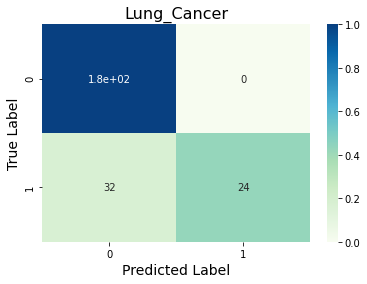

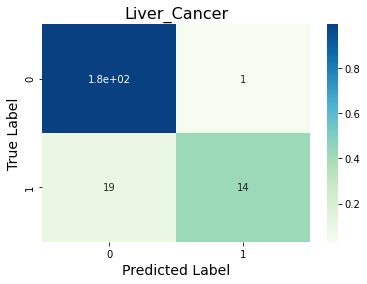

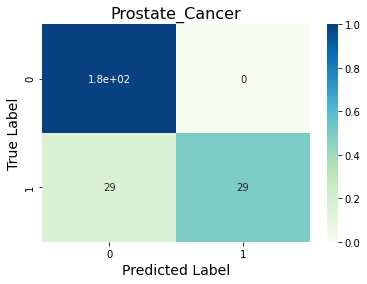

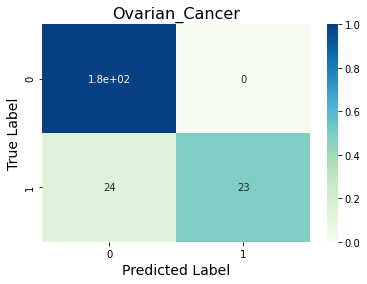

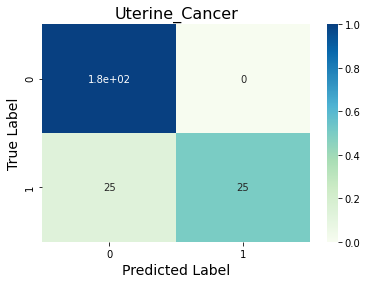

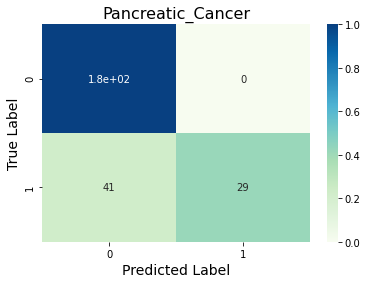

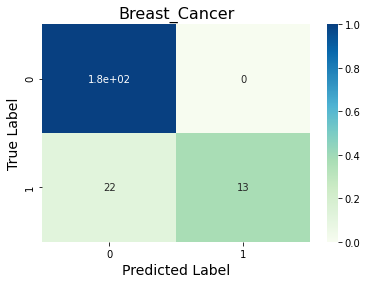

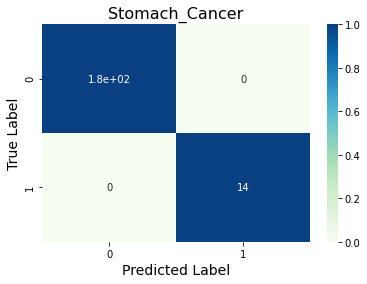

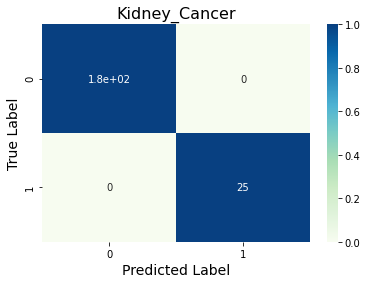

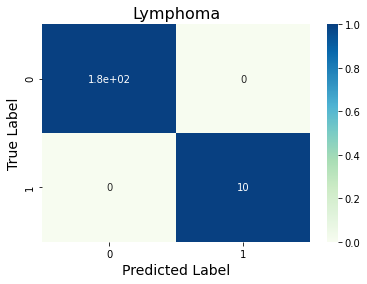

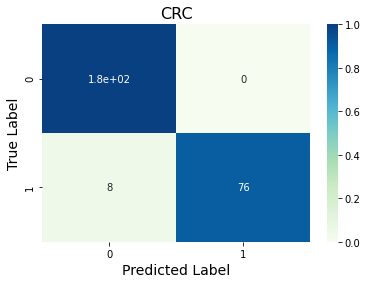

In [37]:
# train one model per tissue type
MIN_FEATURES = 551
outlier_models = {}
#dfs_tissue = []
logreg_models = {}
#dfs_train = []
for cancer_type, tclasses in cancer_type_to_train_sets.items():
    print(cancer_type)
    mat_tissue = mf.create_from_training_classes(training_classes=tclasses + healthy_plasma_train,
                                          feature_str="mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1",
                                          class_labels=[1]*len(tclasses) + [0,0,0]
                                         )    
    outlier_model, df_cancer_healthy = fit_and_transform_data(mat_tissue, MIN_FEATURES)
    print(df_cancer_healthy.shape)
    outlier_models[cancer_type] = outlier_model
    labels = mat_tissue.y
    df_cancer_healthy = pd.DataFrame(df_cancer_healthy[:,:,0] / (df_cancer_healthy[:,:,1] + 1))
    df_cancer_healthy = df_cancer_healthy.apply(lambda x: np.log(x+1), axis=0)
    
    cv = StratifiedKFold(n_splits=3)
    logreg_model = LogisticRegression(multi_class='multinomial', solver='saga', 
                             penalty='l1', C=10)
    logreg_model.fit(X=df_cancer_healthy, y=labels)
    logreg_models[cancer_type] = logreg_model
    y_pred = cross_val_predict(logreg_model, df_cancer_healthy, labels)
    acc = confusion_matrix(labels, y_pred, cancer_type)
    
    

# df_healthy_log = df_healthy.apply(lambda x: np.log(x+1))
# df_healthy_log["cancer_type"] = "healthy" 
# df_train = pd.concat(dfs_train + [df_healthy_log], axis=0)
# df_train = df_train.set_index("cancer_type")

In [38]:
# import test plasma data set, 
dfs_test = []
for cancer_type, tclasses in cancer_type_to_plasma_test_sets.items():
    mat_test = mf.create_from_training_classes(training_classes=tclasses,
                                          feature_str="mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1",
                                          class_labels=[1]*len(tclasses))
    outlier_model = outlier_models[cancer_type]
    fitted_mat_test = outlier_model.transform(mat_test)
    df_fitted_test = pd.DataFrame(fitted_mat_test.x[...,0]/(fitted_mat_test.x[...,1] + 1))
    df_fitted_test = df_fitted_test.apply(lambda x: np.log(x+1))
    df_fitted_test["cancer_type"] = cancer_type
    dfs_test.append(df_fitted_test)

# add healthies
mat_plasma_healthy = mf.create_from_training_classes(training_classes=healthy_plasma_test,
                                          feature_str="mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1",
                                          class_labels=[0]*len(tclasses)
                                         )    
outlier_model = outlier_models["CRC"]
fitted_mat_test = outlier_model.transform(mat_plasma_healthy)
df_fitted_test = pd.DataFrame(fitted_mat_test.x[...,0]/(fitted_mat_test.x[...,1] + 1))
df_fitted_test = df_fitted_test.apply(lambda x: np.log(x+1))
df_fitted_test["cancer_type"] = "healthy"
dfs_test.append(df_fitted_test)
    
df_test = pd.concat(dfs_test, axis=0)
df_test = df_test.set_index("cancer_type")

In [39]:
# score test data on each model in the ensemble, predict with each model, output model scores
cancer_types = list(np.unique(df_test.index))
scores = {}
for cancer_type in cancer_types:
    if cancer_type == "healthy":
        continue
    logreg_model = logreg_models[cancer_type]
    probs = logreg_model.predict_proba(df_test)
    scores[cancer_type] = list([x[1] for x in probs])

df_scores = pd.DataFrame.from_dict(scores)
df_scores = df_scores.set_index(df_test.index)
#print(df_scores.head())
df_scores_healthy = df_scores[df_scores.index=="healthy"]
#print(df_scores_healthy.shape)
healthy_means = df_scores_healthy.mean(axis=0)
#print(healthy_means)
healthy_sds = df_scores_healthy.std(axis=0)
#print(healthy_sds)
df_scores_z = (df_scores - healthy_means)/healthy_sds
#print(df_scores_z.shape)


9
0.0625


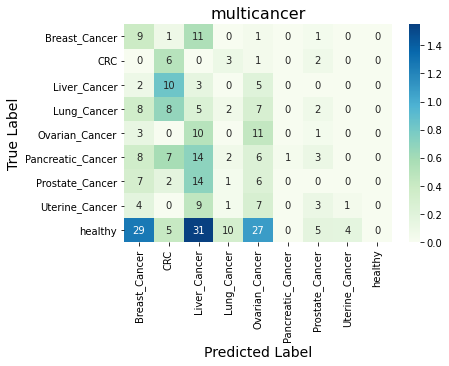

In [40]:
# make TOO calls via max score and construct confusion matrix
max_scores = df_scores_z.apply(max, axis=1)
y_pred = df_scores_z.apply(lambda row: list(df_scores_z.columns)[np.argmax(row)], axis=1)

color_dict = dict(zip(cancer_type_to_train_sets.keys(),
                      ["red","green","magenta","yellow","purple","black","brown","pink","lightblue","lightgreen","orange"]))
color_dict.update({"healthy":"blue"})
acc = confusion_matrix(df_scores_z.index, y_pred, "multicancer")
print(acc)

## Use CV to score plasmas and threshold CRC calls

In [ ]:
# Train Poisson Outlier with max num CRC samples, VP2 regions
# train multicancer model with tissue/plasma training data, VP2 regions
# 1) Classify CRC and multicancer samples with poisson
    # For positive calls, classify TOO
# 2) Classify TOO and 1-healthy prbability
    # For cancer calls classify crc with poisson.

In [7]:
from pineapple.contrib.loaders.experiment_table_loader import ExperimentTableLoader
from pineapple.contrib.results.inference_loader import InferenceResultWithMetadataLoader
from pineappleflow.core.loaders.contrib.inference import InferenceLoader
import os
from sklearn import metrics

In [41]:
# move more healthies to crc train data
# split crc stgIV plasmas to test/train
healthy_plasma_train = ["colorectal_plasma_healthy_polyp_y","colorectal_plasma_healthy_polyp_n",'M4_negs_cpg_dense_no96plasmas_v1']

healthy_plasma_test = ['Neg_noM4_centipedeC_cpg_dense_v3']

cancer_type_to_train_sets = {"Lung_Cancer":["lung_cancer_methyl_DMR_tissue_ds_FF_merged","lung_cancer_centipedeC_cpg_dense_v2_train_v2"],
                             "Liver_Cancer":["liver_cancer_tissue_ds_FF_v1","liver_cancer_centipedeC_cpg_dense_v2_train"],
                             "Prostate_Cancer":["prostate_cancer_tissue_ds_FF_v1","prostate_cancer_centipedeC_cpg_dense_v2_train"],
                             "Ovarian_Cancer":["ovarian_cancer_tissue_ds_FF_v1","ovarian_cancer_centipedeC_cpg_dense_v2_train"],
                             "Uterine_Cancer":["uterine_cancer_tissue_ds_FF_v1","uterine_cancer_centipedeC_cpg_dense_v2_train"],
                             "Pancreatic_Cancer":["pancreatic_cancer_tissue_ds_FF_v1","pancreatic_cancer_centipedeC_cpg_dense_v2_train"],
                             "Breast_Cancer":["breast_cancer_tissue_ds_FF_v1","breast_cancer_centipedeC_cpg_dense_v3_train"],
                             "Stomach_Cancer":["stomach_cancer_tissue_ds_FF_v1"],
                             "Kidney_Cancer":["kidney_cancer_tissue_ds_FF_v1"],
                             "Lymphoma":["nonhodgkinslymphoma_cancer_tissue_ds_FF_v1"],
                             "CRC":["colorectal_tissue_cancer_stage_IV_chemo_n",
                                            "colorectal_tissue_cancer_stage_IV_chemo_y",
                                            "colorectal_tissue_cancer_stage_III_chemo_n",
                                            "colorectal_tissue_cancer_stage_III_chemo_y",
                                            "colorectal_tissue_cancer_stage_II_chemo_n",
                                            "colorectal_tissue_cancer_stage_II_chemo_y",
                                            "colorectal_tissue_cancer_stage_I_chemo_n",
                                            "colorectal_tissue_cancer_stage_I_chemo_y",
                                            "colorectal_plasma_cancer_stage_IV_chemo_yn_train"]
                            }
cancer_type_to_plasma_test_sets = {"Lung_Cancer":["lung_cancer_centipedeC_cpg_dense_v2_test_v2"],
                             "Liver_Cancer":["liver_cancer_centipedeC_cpg_dense_v2_test"],
                             "Prostate_Cancer":["prostate_cancer_centipedeC_cpg_dense_v2_test"],
                             "Ovarian_Cancer":["ovarian_cancer_centipedeC_cpg_dense_v2_test"],
                             "Uterine_Cancer":["uterine_cancer_centipedeC_cpg_dense_v2_test"],
                             "Pancreatic_Cancer":["pancreatic_cancer_centipedeC_cpg_dense_v2_test"],
                             "Breast_Cancer":["breast_cancer_centipedeC_cpg_dense_v3_test"],
                             #"Esophageal_Cancer":["esophageal_cancer_centipedeC_cpg_dense_v1"],
                             "CRC":["colorectal_plasma_cancer_stage_IV_chemo_yn_test"]
                            } 

unsplit_plasmas = {"Lung_Cancer":["lung_cancer_centipedeC_cpg_dense_v2"],
                             "Liver_Cancer":["liver_cancer_centipedeC_cpg_dense_v2"],
                             "Prostate_Cancer":["prostate_cancer_centipedeC_cpg_dense_v2"],
                             "Ovarian_Cancer":["ovarian_cancer_centipedeC_cpg_dense_v2"],
                             "Uterine_Cancer":["uterine_cancer_centipedeC_cpg_dense_v2"],
                             "Pancreatic_Cancer":["pancreatic_cancer_centipedeC_cpg_dense_v2"],
                             "Breast_Cancer":["breast_cancer_centipedeC_cpg_dense_v3"],
                             "Esophageal_Cancer":["esophageal_cancer_centipedeC_cpg_dense_v1"],
                             "CRC":["colorectal_plasma_cancer_stage_IV_chemo_yn_test"]
                            }

In [ ]:
mat = mf.create

In [233]:
def generate_inf_table(bucket, path, feature):
    loader = InferenceLoader(bucket, path)
    smeta = loader.inference_matrix_holder.sample_metadata
    scores = loader.aggregated_model_result.scores
    y = loader.inference_matrix_holder.y
    cancer_type = np.array([sm.cancer_type for idx,sm in enumerate(smeta)])
    #dmeta = loader.inference_matrix_holder.
    matrix = loader.inference_matrix_holder._matrices["mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1"]
    dsids = [dm.raw_dataset_metadata['dataset']['id'] for dm in matrix.dataset_metadata]
    print(Counter(cancer_type))
    stage = np.array([sm.stage for idx,sm in enumerate(smeta)])
    data = pd.DataFrame({"LogScores": np.log10(scores+1),
                         "Stage": stage, 
                         "Scores": scores, 
                         "Label": y, 
                         "CancerType": cancer_type,
                         "dsid": dsids})
    return data

def plot_multicancer_sensitivities(df_inf_results, call_col="call90", score_col="Scores", roc=False):
    cutoff90 = np.percentile(df_inf_results[df_inf_results['Label']==0][score_col], 90) # for inf where all cancers=1 healthy=0
    df_inf_results["call90"] = [1 if score>=cutoff90 else 0 for score in df_inf_results['Scores']]
    
    call_rates = []
    types = []
    for i in np.unique(df_inf_results['cancer_type']):
        if i == "healthy":
            continue
        types.append(i)
        subset = (df_inf_results['Label'] == 0) | (df_inf_results['cancer_type'] == i)
        data_type = df_inf_results[subset]
        n_tp = np.sum([(true==1) and (call==1) for true,call in zip(data_type["Label"],data_type[call_col])])
        call_rates.append(n_tp/len(data_type[data_type["Label"]==1]))
        
        if roc is True:
            fpr, tpr, thresholds = metrics.roc_curve(data_type['Label'], data_type[score_col])
            # correct last step in ROC curve to be compatible with discrete ROC curve
            tpr[-1] = tpr[-2]
            tpr = np.append(tpr,1.)
            fpr = np.append(fpr,1.)
            auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{i} AUC:{'{0:.2}'.format(auc)}")
    
    if roc is True:
        plt.plot([0, 1], [0, 1],color='blue', alpha=0.5, linestyle='dashed', linewidth=1)
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.legend()
        
    fig, ax = plt.subplots()
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    plt.bar(types, call_rates, color=colors )
    plt.ylabel("Per Cancer Sensitivity @ 90 spec")
    plt.ylim([0,1])
    #plt.title(os.path.basename(path))
    plt.xticks(types, rotation=45, ha='right')
    # add bar labels
    for rect, label in zip(ax.patches, call_rates):
        height = 0
        ax.text(rect.get_x() + rect.get_width() / 2, height, f"{(label*100):.2g}%", ha="center", va="bottom")

    return 

Counter({'Normal / Healthy NOS': 75, 'Pancreatic Cancer': 40, 'Pancreatic Normal / Healthy': 36, 'Lung Cancer': 32, 'Prostate Cancer': 30, 'Uterine Cancer': 25, 'Ovarian Cancer': 25, 'Breast Cancer': 23, 'Liver Cancer': 20, 'Colorectal Cancer': 12, 'Pancreatic Pre-Cancer': 1})


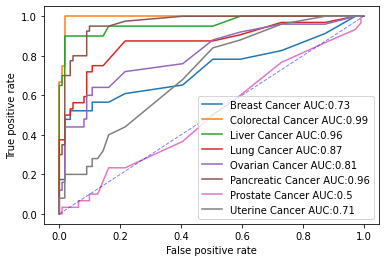

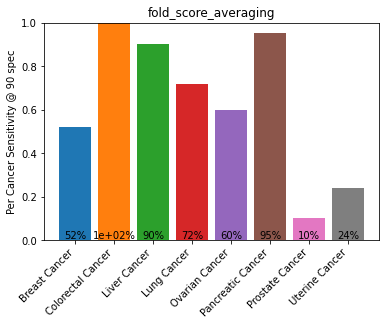

In [88]:
# parse outlier model inference results, output CRC calls
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/Multi_cancer/Two_step_models/CRC_VP2_outlier_model/fold_score_averaging"
feature = "mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1"

df_inf_data = generate_inf_table(bucket, path, feature)
plot_multicancer_sensitivities_from_inf(df_inf_data, plot_roc=True)

In [235]:
#fit train data and inference data to average tissue-specific cpg thresholds
threshold_dict = {}
for cancer_type, tclasses in cancer_type_to_train_sets.items():
    print(cancer_type)
    mat_tissue = mf.create_from_training_classes(training_classes=tclasses + healthy_plasma_train,
                                          feature_str="mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1",
                                          class_labels=[1]*len(tclasses) + [0,0,0]
                                         )    
    df_cancer, df_healthy, cpg_thresholds = fit_data(mat_tissue)
    threshold_dict[cancer_type] = cpg_thresholds

avg_cpg_thresholds = pd.DataFrame.from_dict(threshold_dict).median(axis=1)

def generate_thresholded_data(cancer_type, tclasses):
    mat_test = mf.create_from_training_classes(training_classes=tclasses,
                                          feature_str="mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1",
                                          class_labels=[1]*len(tclasses)
                                         )
    hmf_rates = mat_test.x[...,0]/(mat_test.x[...,1] + 1)
    data = []
    for i , cutoff in enumerate(avg_cpg_thresholds):
        data.append(hmf_rates[:,i,int(np.round(cutoff,0))])
    df_data = pd.DataFrame(data).T # samples x regions
    df_data_log = df_data.apply(lambda x: np.log(x+1))
    df_data_log["cancer_type"] = cancer_type
    df_data_log = df_data_log.set_index(mat_test.dataset_ids)
    return df_data_log
        
dfs_test = []
for cancer_type, tclasses in cancer_type_to_plasma_test_sets.items():
    df_test = generate_thresholded_data(cancer_type, tclasses)
    dfs_test.append(df_test)
# add healthies
df_test = generate_thresholded_data("healthy", healthy_plasma_test)
dfs_test.append(df_test)
df_test = pd.concat(dfs_test, axis=0)
df_test_labels = df_test["cancer_type"]
df_test = df_test.iloc[:,0:-1]

dfs_train = []
for cancer_type, tclasses in cancer_type_to_train_sets.items():
    df_train = generate_thresholded_data(cancer_type, tclasses)
    dfs_train.append(df_train)
# add healthies
df_train = generate_thresholded_data("healthy", healthy_plasma_train)
dfs_train.append(df_train)
df_train = pd.concat(dfs_train, axis=0)
df_train_labels = df_train["cancer_type"]
df_train = df_train.iloc[:,0:-1]


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 43 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


Lung_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 31 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


Liver_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 27 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


Prostate_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 23 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


Ovarian_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 39 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


Uterine_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 42 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


Pancreatic_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 13 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


Breast_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 14 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


Stomach_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 19 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


Kidney_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 9 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


Lymphoma


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 82 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 181 of 183 control samples. 2 samples were over 3.3 sigma.


CRC


In [207]:
# classify inference and train samples in CV with multinomial WITHOUT healthy class

df_train_test = pd.concat([df_train,df_test], axis=0)
df_train_test_labels = np.array(list(df_train_labels) + list(df_test_labels))

# remove healthy samples from training, add back in at prediction time
df_train_test_cancers = df_train_test[[l!="healthy" for l in df_train_test_labels]]
df_train_test_labels_cancers = df_train_test_labels[[l!="healthy" for l in df_train_test_labels]]

cv = StratifiedKFold(n_splits=5)
logreg_model = LogisticRegressionCV(multi_class='multinomial', solver='saga', 
                             penalty='l1', cv=cv) # C is det by hpo search in this model
logreg_model.fit(df_train_test_cancers, df_train_test_labels_cancers)
y_probs = logreg_model.predict_proba(df_train_test)
classes = logreg_model.classes_

# or use CrossValPredict (but this won't give you TOO scores for healthies)
#y_probs = cross_val_predict(logreg_model, df_train_test_cancers, df_train_test_labels_cancers, cv=cv, method="predict_proba")
#classes = np.unique(df_train_test_labels_cancers)
# model classes will be in sort order generated by cross val predict

# or split train and test data for prediction
# df_train_cancer = df_train[[l!="healthy" for l in df_train_labels]]
# df_train_cancer_labels = df_train_labels[[l!="healthy" for l in df_train_labels]]
# logreg_model.fit(X=df_train_cancer, y=df_train_cancer_labels)
# y_probs = logreg_model.predict_proba(df_test)
# classes = logreg_model.classes_
# print(y_probs[0:3,:])

NameError: name 'logreg_mode' is not defined

[0.18481475 0.20799832 0.22865155 0.20672623 0.19325012]


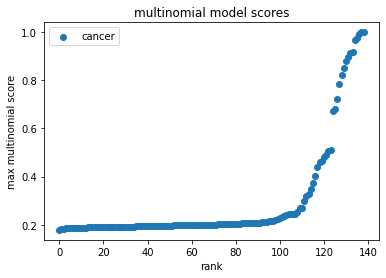

In [209]:
# output TOO predictions for the samples in the inference test set that were called as CRC
classes = logreg_model.classes_
# determine threshold for score cutoff based on max multinomial proba. see what proba distribution is for healthies.
_convert = {"Normal / Healthy NOS":"healthy","Pancreatic Normal / Healthy":"healthy","Breast Cancer":"Breast_Cancer",
           "Colorectal Cancer":"CRC", "Liver Cancer":"Liver_Cancer", "Lung Cancer":"Lung_Cancer", "Ovarian Cancer":"Ovarian_Cancer",
           "Pancreatic Cancer":"Pancreatic_Cancer","Prostate Cancer":"Prostate_Cancer","Uterine Cancer":"Uterine_Cancer",
           "Pancreatic Pre-Cancer":"Pancreatic_Cancer"}

dsid_to_y_probs = dict(zip(df_train_test.index, y_probs))
df_inf_data["cancer_type"] = [_convert[l] for l in df_inf_data["CancerType"]]
df_inf_data["y_probs"] = [dsid_to_y_probs[dsid] for dsid in df_inf_data["dsid"]]

#dsid_to_crc_call = dict(zip(df_inf_data_cancers["dsid"],zip(df_inf_data_cancers["call90"], df_inf_data_cancers["Label"])))
#healthy_test_samples_bool = [dsid_to_crc_call[dsid]==(1,0) for dsid in df_test.index] # healthy samples infered as CRC
# plot multinomial scores for healthies that were called crc
#healthy_scores = np.array([max(dsid_to_y_probs[dsid]) for dsid in df_test.index[healthy_samples_bool]])
#print(healthy_scores[0:5])

plt.figure()
#plt.scatter(range(len(healthy_scores)), sorted(healthy_scores), label="healthy")
#cancer_samples_bool = [dsid_to_crc_call[dsid]==(1,1) for dsid in df_test.index] # cancer samples infered as CRC
df_inf_data_cancers = df_inf_data[df_inf_data["call90"]==1]
cancer_scores = np.array([max(dsid_to_y_probs[dsid]) for dsid in df_inf_data_cancers["dsid"]])
print(cancer_scores[0:5])
plt.scatter(range(len(cancer_scores)), sorted(cancer_scores), label="cancer")

#plt.yscale("log")
plt.ylabel("max multinomial score")
plt.xlabel("rank")
plt.title("multinomial model scores")
plt.legend()
#plt.ylim([0,0.003])
# spec90 = np.percentile(healthy_scores, 90)
# plt.hlines(y=spec90, xmin=0, xmax=210, linestyle="--")

# plt.figure()
# sns.distplot(healthy_scores, label="healthy")
# sns.distplot(cancer_scores, label="cancer")
# plt.vlines(x=spec90, ymin=0, ymax=6.2, linestyle="--", color="black")

(9, 8)
(9, 8)


0.3333333333333333

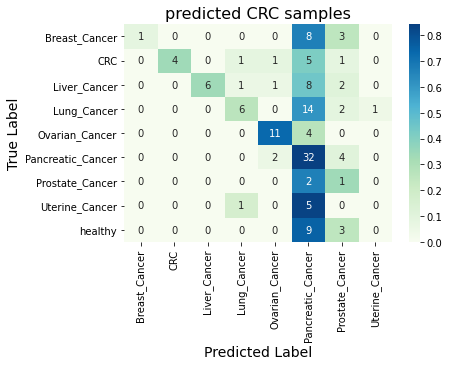

In [212]:
# output CV TOO calls and matrix. recalc sensitivity
df_inf_data_cancers["y_pred_label"] = [classes[np.argmax(row)] for row in df_inf_data_cancers["y_probs"]]

# what we really want to know is what were the TOO predictions for the test samples called CRC
confusion_matrix(list(df_inf_data_cancers["cancer_type"]), df_inf_data_cancers["y_pred_label"], "predicted CRC samples")


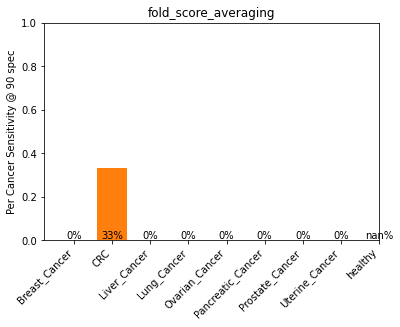

In [224]:
# For all samples classified as CRC, if TOO != CRC classify as neg. sens = tp/tp+fn. spec = tn/tn+fp

df_inf_data["y_pred_label"] = [classes[np.argmax(row)] for row in df_inf_data["y_probs"]]

new_calls = []
for a,b in zip(df_inf_data["call90"],df_inf_data["y_pred_label"]):
    if a == 1 and b == "CRC":
        new_calls.append(1)
    elif a ==1 and b!="CRC":
        new_calls.append(0)
    elif a == 0:
        new_calls.append(0)
df_inf_data["too_updated_call"] = new_calls
# metrics for CRC poisson model inference alone
plot_multicancer_sensitivities(df_inf_data, call_col="too_updated_call", roc=False)

In [230]:
print(classes)

['Breast_Cancer' 'CRC' 'Kidney_Cancer' 'Liver_Cancer' 'Lung_Cancer'
 'Lymphoma' 'Ovarian_Cancer' 'Pancreatic_Cancer' 'Prostate_Cancer'
 'Stomach_Cancer' 'Uterine_Cancer']


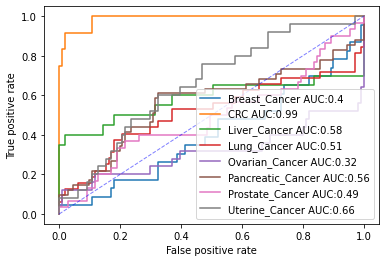

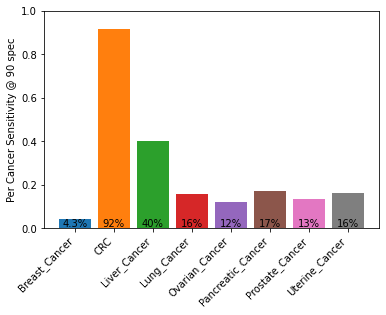

In [234]:
# Plot ROC curve thresholded on prob CRC. Plot beside ROC thresholded on inference model score.

df_inf_data["too_prob_crc"] = [p[1] for p in df_inf_data["y_probs"]]

cutoff = np.percentile(df_inf_data[df_inf_data["Label"]==0]["too_prob_crc"], 90)
df_inf_data["call90_too_score"] = [1 if s >= cutoff else 0 for s in df_inf_data['too_prob_crc']]

plot_multicancer_sensitivities(df_inf_data, call_col="call90_too_score", score_col="too_prob_crc",roc=True)

In [237]:
# classify inference and train samples in CV with multinomial WITH healthy class

df_train_test = pd.concat([df_train,df_test], axis=0)
df_train_test_labels = np.array(list(df_train_labels) + list(df_test_labels))

# remove healthy samples from training, add back in at prediction time
#df_train_test_cancers = df_train_test[[l!="healthy" for l in df_train_test_labels]]
#df_train_test_labels_cancers = df_train_test_labels[[l!="healthy" for l in df_train_test_labels]]

cv = StratifiedKFold(n_splits=5)
logreg_model = LogisticRegressionCV(multi_class='multinomial', solver='saga', 
                             penalty='l1', cv=cv) # C is det by hpo search in this model
logreg_model.fit(df_train_test, df_train_test_labels)
y_probs = logreg_model.predict_proba(df_train_test)
classes = logreg_model.classes_

(9, 8)
(9, 8)


0.32456140350877194

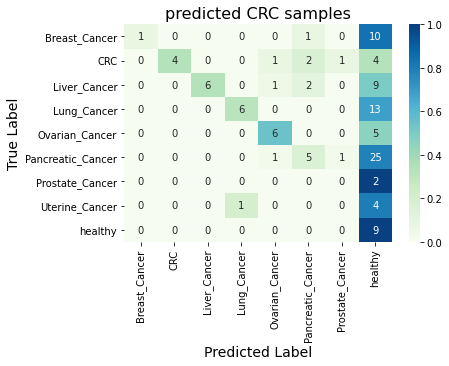

In [239]:
classes = logreg_model.classes_
# determine threshold for score cutoff based on max multinomial proba. see what proba distribution is for healthies.
_convert = {"Normal / Healthy NOS":"healthy","Pancreatic Normal / Healthy":"healthy","Breast Cancer":"Breast_Cancer",
           "Colorectal Cancer":"CRC", "Liver Cancer":"Liver_Cancer", "Lung Cancer":"Lung_Cancer", "Ovarian Cancer":"Ovarian_Cancer",
           "Pancreatic Cancer":"Pancreatic_Cancer","Prostate Cancer":"Prostate_Cancer","Uterine Cancer":"Uterine_Cancer",
           "Pancreatic Pre-Cancer":"Pancreatic_Cancer"}

dsid_to_y_probs = dict(zip(df_train_test.index, y_probs))
df_inf_data["cancer_type"] = [_convert[l] for l in df_inf_data["CancerType"]]
df_inf_data["y_probs"] = [dsid_to_y_probs[dsid] for dsid in df_inf_data["dsid"]]

df_inf_data_cancers = df_inf_data[df_inf_data["call90"]==1]
cancer_scores = np.array([max(dsid_to_y_probs[dsid]) for dsid in df_inf_data_cancers["dsid"]])

# output CV TOO calls and matrix. recalc sensitivity
df_inf_data_cancers["y_pred_label"] = [classes[np.argmax(row)] for row in df_inf_data_cancers["y_probs"]]

# what we really want to know is what were the TOO predictions for the test samples called CRC
confusion_matrix(list(df_inf_data_cancers["cancer_type"]), df_inf_data_cancers["y_pred_label"], "predicted CRC samples")

# pineapple model

In [1]:
from pineapple.contrib.loaders.experiment_table_loader import ExperimentTableLoader
from pineappleflow.core.loaders.contrib import ExperimentLoader
from sklearn import metrics

STATISTICAL TESTS: The most common metric functions have been moved to Pineappleflow. Please import by 'from pineappleflow.core.statistics_utils'. Currently includes: SensAndSpecMetrics, get_sens_and_spec, specificity_threshold_interpolated, specificity_thresholds


In [20]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/combine_outlier_logreg"

loader = ExperimentLoader(bucket,path)
table_loader = ExperimentTableLoader.from_experiment_loader(loader)
df_samples = table_loader.sample_score_per_fold_table()

df_samples['score_mean'] = df_samples.groupby(['sample_id'])['y_score'].transform(lambda x: np.mean(x))
df_samples = df_samples.drop_duplicates()

df_samples.head()

,sample_id,fold,y_true,y_score,status,stage,subtype,inference,score_mean
0,4991,metadata_balanced_kfold_cancer_type_0,0,-0.154128,Breast Cancer,2,None,False,-0.154128
1,5006,metadata_balanced_kfold_cancer_type_0,0,-0.154128,Breast Cancer,2,None,False,-0.154128
2,19725,metadata_balanced_kfold_cancer_type_0,0,-0.154128,Colorectal Normal / Healthy,None,None,False,-0.154128
3,20084,metadata_balanced_kfold_cancer_type_0,0,-0.154128,Pancreatic Pre-Cancer,None,None,False,-0.154128
4,20235,metadata_balanced_kfold_cancer_type_0,0,-0.154128,Colorectal Normal / Healthy,None,None,False,-0.154128


In [6]:
Counter(df_samples["status"])

Counter({'Breast Cancer': 46,
         'Colorectal Normal / Healthy': 95,
         'Pancreatic Pre-Cancer': 3,
         'Colorectal Cancer': 24,
         'Prostate Cancer': 59,
         'Pancreatic Cancer': 80,
         'Uterine Cancer': 51,
         'Lung Cancer': 64,
         'Esophageal Cancer': 56,
         'Liver Cancer': 39,
         'Ovarian Cancer': 50})

In [21]:
df_healthies = df_samples[df_samples["status"]=="Colorectal Normal / Healthy"]

cutoff = np.percentile(df_healthies["y_score"], 90)

df_samples["call90"] = [1 if s>cutoff else 0 for s in df_samples["y_score"]]
df_samples.head()

,sample_id,fold,y_true,y_score,status,stage,subtype,inference,score_mean,call90
0,4991,metadata_balanced_kfold_cancer_type_0,0,-0.154128,Breast Cancer,2,None,False,-0.154128,0
1,5006,metadata_balanced_kfold_cancer_type_0,0,-0.154128,Breast Cancer,2,None,False,-0.154128,0
2,19725,metadata_balanced_kfold_cancer_type_0,0,-0.154128,Colorectal Normal / Healthy,None,None,False,-0.154128,0
3,20084,metadata_balanced_kfold_cancer_type_0,0,-0.154128,Pancreatic Pre-Cancer,None,None,False,-0.154128,0
4,20235,metadata_balanced_kfold_cancer_type_0,0,-0.154128,Colorectal Normal / Healthy,None,None,False,-0.154128,0


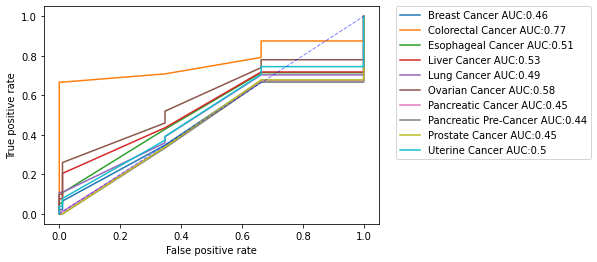

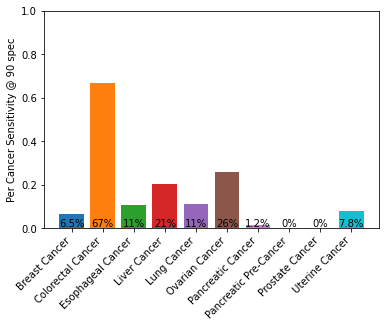

In [22]:
call_rates = []
types = []
for i in np.unique(df_samples['status']):
    if i == "Colorectal Normal / Healthy":
        continue
    types.append(i)
    subset = (df_samples['status'] == "Colorectal Normal / Healthy") | (df_samples['status'] == i)
    data_type = df_samples[subset]
    data_type["y_true_new"] = [1 if l==i else 0 for l in data_type["status"]]
    n_tp = np.sum([(true==1) and (call==1) for true,call in zip(data_type["y_true_new"],data_type["call90"])])
    call_rates.append(n_tp/len(data_type[data_type["y_true_new"]==1]))
    
    fpr, tpr, thresholds = metrics.roc_curve(data_type['y_true_new'], data_type["y_score"])
    # correct last step in ROC curve to be compatible with discrete ROC curve
    tpr[-1] = tpr[-2]
    tpr = np.append(tpr,1.)
    fpr = np.append(fpr,1.)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{i} AUC:{'{0:.2}'.format(auc)}")

plt.plot([0, 1], [0, 1],color='blue', alpha=0.5, linestyle='dashed', linewidth=1)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
fig, ax = plt.subplots()
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.bar(types, call_rates, color=colors )
plt.ylabel("Per Cancer Sensitivity @ 90 spec")
plt.ylim([0,1])
#plt.title(os.path.basename(path))
plt.xticks(types, rotation=45, ha='right')
# add bar labels
for rect, label in zip(ax.patches, call_rates):
    height = 0
    ax.text(rect.get_x() + rect.get_width() / 2, height, f"{(label*100):.2g}%", ha="center", va="bottom")
